In [18]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import torch
import torch.nn.functional as F

def Y_L(x):
#     if (x<0.5):
#         return (0.5*(6*x-2)*(6*x-2)*math.sin(12*x-4))+(10*(x-0.5))-5
#     else:
#         return 3+(0.5*(6*x-2)*(6*x-2)*math.sin(12*x-4))+(10*(x-0.5))-5
    
    return 0.5*(6*x-2)*(6*x-2)*math.sin(12*x-4)+10*(x-0.5)-5
def Y_H(x):
#     if (x<0.5):
#         return 2*Y_L(x)-20*x+20
#     else:
#         return 4+2*Y_L(x)-20*x+20
    
    return (6*x-2)*(6*x-2)*math.sin(12*x-4)
H_x = []
H_y = []
H_yl = []
for i in range(0,100,1):
    H_x.append(i/100)
    H_y.append(Y_H(i/100))
    H_yl.append(Y_L(i/100))

H_training_input = np.array([0.2,0.4,0.6,0.8,0.9])
output_list = []     ## output list of high fidelity 
output_list_l = []   ## output list of low fidelity 
for i in range(0,5,1):
    output_list.append(Y_H(H_training_input[i]))
    output_list_l.append(Y_L(H_training_input[i]))
H_training_output = np.asarray(output_list)
H_training_output_l = np.asarray(output_list_l)

In [19]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 5, 1, 20, 1

H_training_input1 = H_training_input.reshape((5,1))
H_training_input2 = H_training_input1.transpose()

H_training_output1 = H_training_output.reshape((5,1))
H_training_output2 = H_training_output1.transpose()

H_training_output1_l = H_training_output_l.reshape((5,1))
H_training_output2_l = H_training_output1_l.transpose()

print(type(H_training_input),'###',H_training_input.shape,H_training_input2.shape)

x1 = torch.from_numpy(H_training_input2).float()
y1 = torch.from_numpy(H_training_output2).float()
y1_l = torch.from_numpy(H_training_output2_l).float()

x = x1.t()
y = y1.t()
y_l = y1_l.t()


<class 'numpy.ndarray'> ### (5,) (1, 5)


In [20]:
# pytorch model

%run models_for_multi.ipynb

In [21]:
model1 = DNN_LF(D_in, H, D_out)
model2 = DNN_HF_1(D_in+1, H, D_out)
model3 = DNN_HF_2(D_in+1, H, D_out)

# vanilla stochastic gradient descent is tough, so we use momentum
loss11 = torch.nn.MSELoss(reduction='sum')
loss12 = torch.nn.MSELoss(reduction='sum')
loss2  = torch.nn.MSELoss(reduction='sum')

# alpha = torch.rand(1, requires_grad=True,device= "cpu")
alpha = torch.rand(1).to('cpu').detach().requires_grad_(True)
optimizer = torch.optim.Adam(list(model1.parameters())+list(model2.parameters())+list(model3.parameters())+[alpha], lr=1e-4,weight_decay=1e-7)
print('Alpha before training',alpha)

Alpha before training tensor([0.3450], requires_grad=True)


In [22]:
# optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-3, momentum=0.8)
# optimizer3 = torch.optim.SGD(model3.parameters(), lr=1e-3, momentum=0.8)

for t in range(10000):
    y_l_p   = model1(x)
#     y_l_p_g = torch.autograd.grad(y_l_p, x, 
#                            grad_outputs= y_l_p.data.new(y_l_p.shape).fill_(1),
#                            create_graph=True)
    h_1 = model2(y_l_p,x)
    h_2 = model3(y_l_p,x)
    y_h = alpha * h_1 + (1-alpha)*h_2
    
    # Compute and print loss
    loss_yl = loss11(y_l_p, y_l)  
#     loss_yl_g = loss12(y_l_p_g, y_l)  
    loss_yh = loss2(y_h,y)
    loss = loss_yl + loss_yh
    if(t%10 == 0):
        print(t, loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 209.84320068359375
10 209.51437377929688
20 209.1959991455078
30 208.90635681152344
40 208.62295532226562
50 208.34487915039062
60 208.06417846679688
70 207.78323364257812
80 207.5093536376953
90 207.22804260253906
100 206.94558715820312
110 206.66595458984375
120 206.38436889648438
130 206.10104370117188
140 205.8153839111328
150 205.52655029296875
160 205.2315216064453
170 204.929443359375
180 204.62109375
190 204.30975341796875
200 203.99412536621094
210 203.6726531982422
220 203.34567260742188
230 203.011962890625
240 202.6712646484375
250 202.32333374023438
260 201.97445678710938
270 201.62643432617188
280 201.27252197265625
290 200.9108123779297
300 200.69351196289062
310 200.6247100830078
320 200.5355224609375
330 200.45799255371094
340 200.37884521484375
350 200.30172729492188
360 200.2259521484375
370 200.15151977539062
380 200.07791137695312
390 200.00564575195312
400 199.9358673095703
410 199.8673553466797
420 199.80255126953125
430 199.7411346435547
440 199.680908203125
4

3600 152.42613220214844
3610 152.42539978027344
3620 152.42465209960938
3630 152.42381286621094
3640 152.42311096191406
3650 152.4917755126953
3660 152.44296264648438
3670 152.4259033203125
3680 152.42645263671875
3690 152.42428588867188
3700 152.4230194091797
3710 152.42234802246094
3720 152.42153930664062
3730 152.4893798828125
3740 152.43211364746094
3750 152.4292755126953
3760 152.4261932373047
3770 152.42237854003906
3780 152.42164611816406
3790 152.4207763671875
3800 152.41989135742188
3810 152.419677734375
3820 152.45445251464844
3830 152.4415283203125
3840 152.42269897460938
3850 152.42140197753906
3860 152.42054748535156
3870 152.41903686523438
3880 152.41819763183594
3890 152.4174041748047
3900 152.41976928710938
3910 152.4513397216797
3920 152.44004821777344
3930 152.4206085205078
3940 152.41880798339844
3950 152.41806030273438
3960 152.41650390625
3970 152.4156036376953
3980 152.41477966308594
3990 152.4995880126953
4000 152.4302978515625
4010 152.4193878173828
4020 152.419

7130 152.27981567382812
7140 152.2736358642578
7150 152.271240234375
7160 152.37721252441406
7170 152.27845764160156
7180 152.28004455566406
7190 152.2769317626953
7200 152.2707977294922
7210 152.26832580566406
7220 152.26597595214844
7230 152.31307983398438
7240 152.29400634765625
7250 152.27227783203125
7260 152.26889038085938
7270 152.26559448242188
7280 152.2631072998047
7290 152.36399841308594
7300 152.2698211669922
7310 152.2713165283203
7320 152.2681121826172
7330 152.26251220703125
7340 152.2685546875
7350 152.30026245117188
7360 152.28318786621094
7370 152.26382446289062
7380 152.2617645263672
7390 152.25942993164062
7400 152.25665283203125
7410 152.2543182373047
7420 152.29904174804688
7430 152.28076171875
7440 152.26109313964844
7450 152.2574462890625
7460 152.2537078857422
7470 152.25115966796875
7480 152.25660705566406
7490 152.29049682617188
7500 152.27561950683594
7510 152.2541046142578
7520 152.25096130371094
7530 152.2481231689453
7540 152.28106689453125
7550 152.27534

In [23]:
print('alpha after training',alpha)

alpha after training tensor([0.1515], requires_grad=True)


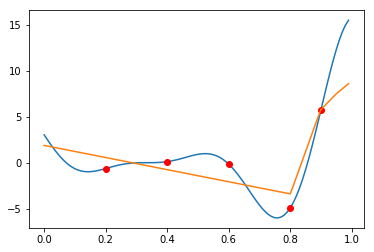

In [24]:
temp = np.asarray(H_x)
temp1 = temp.reshape((100,1))
temp2 = temp1.transpose()
t1 = torch.FloatTensor(temp2)
t = t1.t()

Ttemp  = np.asarray(H_x)
Ttemp1 = Ttemp.reshape((100,1))
Ttemp2 = Ttemp1.transpose()
Tt1    = torch.FloatTensor(Ttemp2)
Tt     = Tt1.t()


p_l = model1(t)
p_h_1 = model2(p_l,t)
p_h_2 = model3(p_l,t)
# p_h_1 = model2(Tt,t)
# p_h_2 = model3(Tt,t)
prediction = alpha * p_h_1 + (1-alpha)*p_h_2

plt.plot(H_x,H_y,H_training_input,H_training_output,'ro',H_x,prediction.tolist())
plt.show()
